In [189]:
import numpy as np
import matplotlib.pyplot as plt
import numexpr as ne
from scipy import misc
from PIL import Image
from itertools import product, chain
import networkx as nx
import pandas as pd
from heapq import heappush, heappop
import collections

%matplotlib inline

The _objective_ is to find a $path$ through a radioactive $\textbf{wasteland}$.

In [190]:
# The code in this cell was taken from here: https://github.com/DanielStutzbach/heapdict
class heapdict(collections.MutableMapping):
    __marker = object()

    @staticmethod
    def _parent(i):
        return ((i - 1) >> 1)

    @staticmethod
    def _left(i):
        return ((i << 1) + 1)

    @staticmethod
    def _right(i):
        return ((i+1) << 1)    
    
    def __init__(self, *args, **kw):
        self.heap = []
        self.d = {}
        self.update(*args, **kw)

    def clear(self):
        del self.heap[:]
        self.d.clear()

    def __setitem__(self, key, value):
        if key in self.d:
            self.pop(key)
        wrapper = [value, key, len(self)]
        self.d[key] = wrapper
        self.heap.append(wrapper)
        self._decrease_key(len(self.heap)-1)

    def _min_heapify(self, i):
        l = self._left(i)
        r = self._right(i)
        n = len(self.heap)
        if l < n and self.heap[l][0] < self.heap[i][0]:
            low = l
        else:
            low = i
        if r < n and self.heap[r][0] < self.heap[low][0]:
            low = r

        if low != i:
            self._swap(i, low)
            self._min_heapify(low)

    def _decrease_key(self, i):
        while i:
            parent = self._parent(i)
            if self.heap[parent][0] < self.heap[i][0]: break
            self._swap(i, parent)
            i = parent

    def _swap(self, i, j):
        self.heap[i], self.heap[j] = self.heap[j], self.heap[i]
        self.heap[i][2] = i
        self.heap[j][2] = j

    def __delitem__(self, key):
        wrapper = self.d[key]
        while wrapper[2]:
            parentpos = self._parent(wrapper[2])
            parent = self.heap[parentpos]
            self._swap(wrapper[2], parent[2])
        self.popitem()

    def __getitem__(self, key):
        return self.d[key][0]

    def __iter__(self):
        return iter(self.d)

    def popitem(self):
        """D.popitem() -> (k, v), remove and return the (key, value) pair with lowest\nvalue; but raise KeyError if D is empty."""
        wrapper = self.heap[0]
        if len(self.heap) == 1:
            self.heap.pop()
        else:
            self.heap[0] = self.heap.pop(-1)
            self.heap[0][2] = 0
            self._min_heapify(0)
        del self.d[wrapper[1]]
        return wrapper[1], wrapper[0]    

    def __len__(self):
        return len(self.d)

    def peekitem(self):
        """D.peekitem() -> (k, v), return the (key, value) pair with lowest value;\n but raise KeyError if D is empty."""
        return (self.heap[0][1], self.heap[0][0])

In [191]:
ne.set_num_threads(4)
ne.set_vml_num_threads(4)
ne.detect_number_of_cores()
ne.set_vml_accuracy_mode('fast')

'fast'

In [335]:
def read_map(file):
    # white — 255; black — 0; red — 91; green — 122; orange — 155
    return misc.imread(file, mode='L')

def save_radiation(filename, radiation):
    np.save(filename, radiation)
    
def load_radiation(filename):
    return np.load(filename)

In [193]:
def metric(x, y, i, j):
    return ne.evaluate("sqrt((x - i)**2 + (y - j)**2)")

def radiation(x):
    return ne.evaluate("10**5 / (x ** 2)")

def dose(x, y):
    return lambda i,j: radiation(metric(x, y, i, j))

def generate_radiation(x, y, size=700):
    return np.fromfunction(dose(x, y), (size, size))

In [194]:
map = read_map(r'./map.png')
radiation_cells = np.array(list(zip(*np.where(map == 155))))
obstacle_cells = np.array(list(zip(*np.where(map == 0))))
start_cell = np.array(list(zip(*np.where(map == 122))))[0]
finish_cell = np.array(list(zip(*np.where(map == 91))))[0]

In [197]:
# a = np.sum(generate_radiation(i, j) for i, j in radiation_cells)
a = load_radiation('radiation.npy')

In [78]:
obstacle_coords = pd.DataFrame(obstacle_cells).apply(lambda x: str((x[0], x[1])), axis=1).as_matrix()

In [345]:
dist = np.tile(float('inf'), (700, 700))
color = np.zeros((700, 700))
prev = np.tile(-1, (700, 700)).astype(str)

i,j = start_cell
initial_rads = a[i][j]
dist[i][j] = 0

In [333]:
Q_test = heapdict()
for i in range(700):
    for j in range(700):
        if str((i, j)) in obstacle_coords:
            continue
        if i == start_cell[0] and j == start_cell[1]:
            Q_test[(i, j)] = 0
        else:
            Q_test[(i, j)] = float('inf')    

In [348]:
def dijk(Q_test, dist, prev):
    while len(Q_test) != 0:
        (i, j), rad = Q_test.popitem()
        for iv, jv in neighbors(i, j):
            if str((i, j)) in obstacle_coords:
                continue
            alt = dist[i, j] + a[iv, jv]
            if alt < dist[iv, jv]:
                dist[iv, jv] = alt
                prev[iv, jv] = str((i, j))
                Q_test[(iv, jv)] = alt
        
        if len(Q_test) % 50000 == 0:
            print(len(Q_test))
    return dist, prev

In [343]:
dist_copy = dist.copy()
prev_copy = prev.copy()

In [351]:
second_dist, seconds_prev = dijk(Q_test, dist, prev)

450000
400000
350000
300000
250000
200000
150000
100000
50000
0


In [305]:
def get_pair(string):
    i, j = string.replace("(", "").replace(")", "").replace(" ", "").split(',')
    return int(i), int(j)

In [325]:
def get_path(prevs, start, finish):
    path = []
    current = finish
    while current != start:
        path.append(current)
        current = prevs[get_pair(current)]
    return [eval(_) for _ in list(reversed(path))]

In [326]:
start_tuple = start_cell[0], start_cell[1]
finish_tuple = finish_cell[0], finish_cell[1]

In [377]:
path = get_path(seconds_prev, str(start_tuple), str(finish_tuple))

In [439]:
def get_path_length(path):
    '''
    Count the length of the path, 
    taking diagonal moves into account.
    '''
    moves = 0.
    path = [np.array(v) for v in path]
    for left, right in zip(path, path[1:]):
        distance = np.sqrt(np.abs(left - right).sum())
        moves = moves + distance
    return np.int(np.ceil(moves))

In [442]:
"Length of the path is " + str(get_path_length(path))

'Length of the path is 1290'

$Length$ is $1290$ which is less than $1300$. It was required to get the path with $length$ less than $1300$.

In [373]:
np.save("prev_results", seconds_prev)

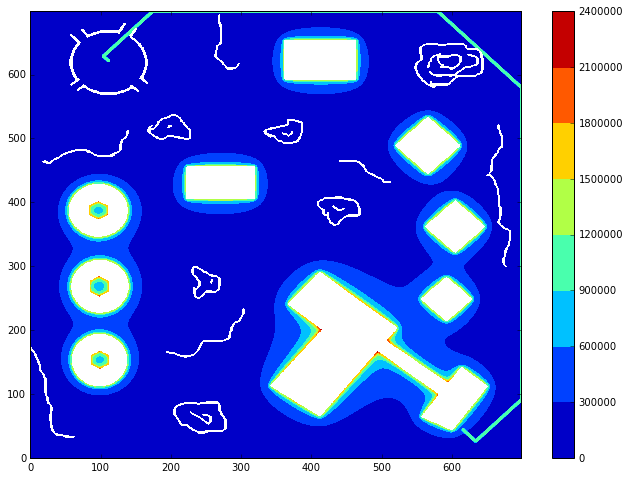

In [372]:
picture = a.copy()
# for i, j in get_path(new_prev, str(start_tuple), str(finish_tuple)):
for i, j in get_path(seconds_prev, str(start_tuple), str(finish_tuple)):
    picture[i][j] = float('inf')
    for x, y in neighbors(i, j):
        picture[x][y] = float('1000000')
        
for i, j in obstacle_cells:
    picture[i][j] = float('-inf')
        
plt.figure(figsize=(11, 8))
im = plt.contourf(picture)
plt.colorbar(im, orientation='vertical')
plt.show()

In [8]:
save_radiation('radiation', a)

In [130]:
# Graph generation routines
def neighbors(i, j, width=700, height=700):
    neighbors_i = [i - 1, i, i + 1]
    neighbors_j = [j - 1, j, j + 1]
    neighbors = []
    for i, j in product(neighbors_i, neighbors_j):
        if 0 <= i < width and 0 <= j < height:
            yield (i, j)
    

def get_edges_from(map, i, j):
    return [(x, y, map[x][y]) for x, y in neighbors(i, j, map.shape[0], map.shape[1])]